# Jake Vanderplas' Methodology for Git, GitHub, Modules, and Reproducibility
[YouTube video series](https://www.youtube.com/watch?v=_ZEWDGpM-vM&list=PLYCpMb24GpOC704uO9svUrihl-HY1tTJJ)

In [21]:
# use the budget_tool environment in Conda

import os
import pandas as pd

import matplotlib.pyplot as plt
# much nicer style for matplotlib plots
plt.style.use('seaborn')

import numpy as np

# module we built in this class - it is stored in the project folder
from datadownloader.data import get_fremont_data

# turns on verbose errors messages which display variable values - very helpful for debugging
%xmode Verbose  

Exception reporting mode: Verbose


In [22]:
# Unix command to see the first 10 lines of the file ("!" indicates that this is a bash command)
!head data/Fremont.csv

Date,Total,East,West
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0
2019-11-01 05:00:00,20.0,9.0,11.0
2019-11-01 06:00:00,97.0,43.0,54.0
2019-11-01 07:00:00,299.0,120.0,179.0
2019-11-01 08:00:00,583.0,261.0,322.0


In [23]:
# load or download the data directly into dataframe
URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'
data = get_fremont_data(URL)

In [24]:
# this measures the time to execute the whole cell 
#%%timeit -r1 -n1   #set the number and repeats of loops
# use %timeit directyly in front of a specific command (separated by a space) 
# if you want just the command instead of the whole cell

# import and automatically parse the datetime data - this is the slow method, 
# later he teaches how to identify the format which drammatically speeds up the 
# datetime parsing
data = pd.read_csv('data/Fremont.csv', index_col='Date', parse_dates=True)

In [25]:
data

,Total,East,West
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0
...,...,...,...
2021-11-30 19:00:00,72.0,24.0,48.0
2021-11-30 20:00:00,26.0,8.0,18.0
2021-11-30 21:00:00,29.0,15.0,14.0


In [26]:
# the dates are jumbled in my copy of the data. sorting just for OCD purposes.
data.sort_index(inplace=True)
data

,Total,East,West
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
...,...,...,...
2021-11-30 19:00:00,72.0,24.0,48.0
2021-11-30 20:00:00,26.0,8.0,18.0
2021-11-30 21:00:00,29.0,15.0,14.0


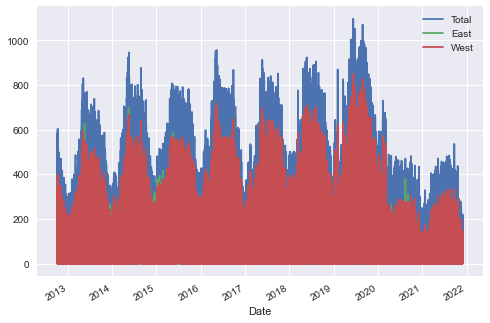

In [27]:
data.plot();

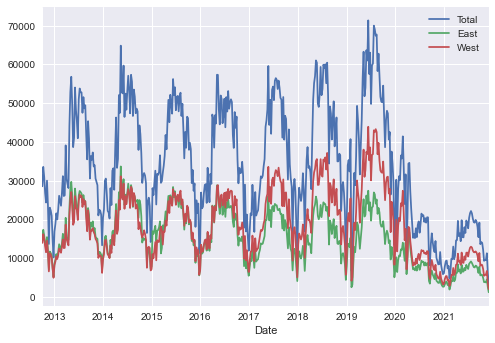

In [28]:
# since the data is so dense, can reduce it by resampling to counts for the week instead 
# of individual days
data.resample('W').sum().plot();

# Part 2

In [29]:
# How to do a rolling average for 365 days
resample = data.resample('D').sum().rolling(365).mean()

# drops the first 365 days of data since they don't have a years worth of data to average
resample.dropna(inplace=True)    
resample = resample.astype('int32')
resample.head(3)

,Total,East,West
Date,,,
2013-10-02,4942,2546,2395
2013-10-03,4940,2546,2394
2013-10-04,4939,2546,2393


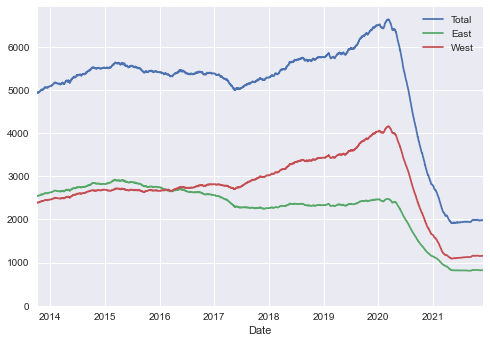

In [30]:
ax = resample.plot();
ax.set_ylim(0, None); # None means use the current maximum

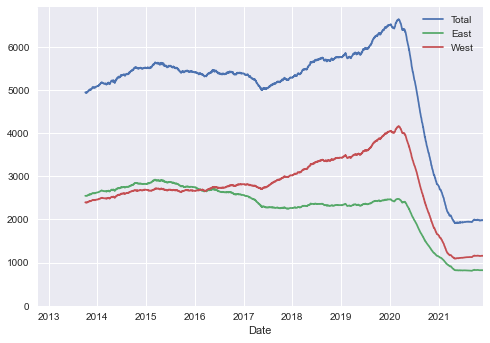

In [31]:
# How to do a rolling average directly
ax = data.resample('D').sum().rolling(365).mean().plot();
ax.set_ylim(0, None);  # None means use the current maximum

# Break from to JakeVDP's Instructions
Jake released this video series in 2017. The data has drammatically changed since then (as of January 2022) due to the pandemic. His analysis on the pre-pandemic data resulted in really nice separations between weekday and weekend traffic patterns. But, traffic patters on weekdays are significantly different during the pandemic. I need a "pandemic start date" for breaking the dataset into two groups for analysis below. I'm going to do a simple bifurcation of the data. A better approach might be to break the data into "pre", "transitional", and "pandemic" but I'm not to worries since it's only a few weeks of "transitional" data and won't skew the results very much.

In [32]:
pandemic_start_window = data['Total'].loc['2020-01-01':'2020-12-01'].resample('W').sum()
prepandemic_equivalent_window = data['Total'].loc['2019-01-01':'2019-12-01'].resample('W').sum()

In [33]:
pandemic_start_window.head(3)

Date
2020-01-05    13992.0
2020-01-12    30264.0
2020-01-19    18246.0
Freq: W-SUN, Name: Total, dtype: float64

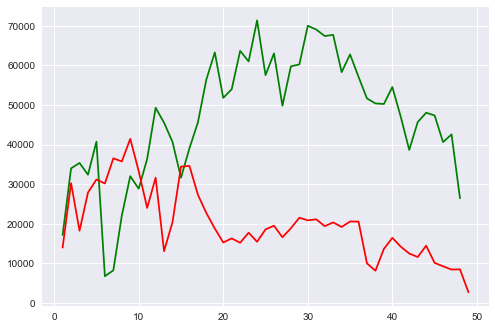

In [34]:
# originally, I was using: 
#
#   plt.plot(prepandemic_equivalent_window.index.week, prepandemic_equivalent_window, color='g', label=2019)
#   plt.plot(pandemic_start_window.index.week, pandemic_start_window, color='r', label=2020)
#
# but was getting a FutureWarning about this capability being depricated. so, instead now I'm using 
# the much more verbose method described in the warning. there is probably a more pythonic way to do
# this but I don't know how yet. the "prepandemic_equivalent_window.index.isocalendar().week" returns
# a series which has to be converted to an index instead of where the old function 
# "pandemic_start_window.index.week" returned the index directly.

plt.plot(pd.Int64Index(prepandemic_equivalent_window.index.isocalendar().week), prepandemic_equivalent_window, color='g', label=2019)
plt.plot(pd.Int64Index(pandemic_start_window.index.isocalendar().week), pandemic_start_window, color='r', label=2020);

In [35]:
# visually you can see the full impact of the pandemic begins at week 20, thus we'll use this 
# as the breakpoint for pre-pandemic to pandemic. The below shows the starting date for week
# 20 in 2020 (based on the number of Sundays in the year to date).
pandemic_start_window[pandemic_start_window.index.isocalendar().week == 20]

Date
2020-05-17    15280.0
Freq: W-SUN, Name: Total, dtype: float64

In [36]:
pandemic_start_date = pandemic_start_window[pandemic_start_window.index.isocalendar().week == 20].index.date[0]
pandemic_start_date

datetime.date(2020, 5, 17)

# Resuming Part 2

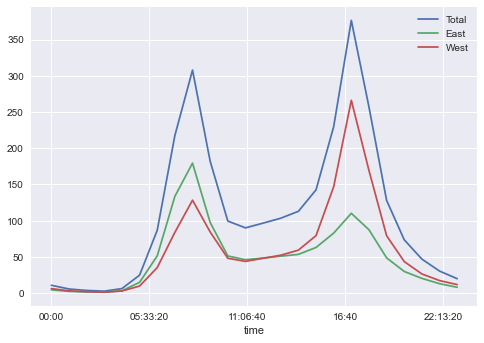

In [37]:
hourly_data  = data.groupby(data.index.time).mean()
# data.index.time pulls out just the hour from the index - can also use date, year, 
# month, day, hour, minute, or second to get those portions of the data from the index.

hourly_data.plot();

In [38]:
# pivot so that it's hours for rows and days for columns - tell it to use the 
# 'Total' column, not East or West
pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
print(pivoted.shape)
pivoted.iloc[:5,:5]   # look at just the first 5x5 block of the data

(24, 3345)


,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


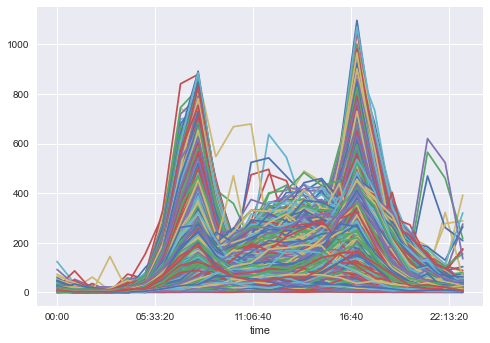

In [66]:
# plot the traffic data for each day on a 24-hour x-axis
pivoted.plot(legend=False);

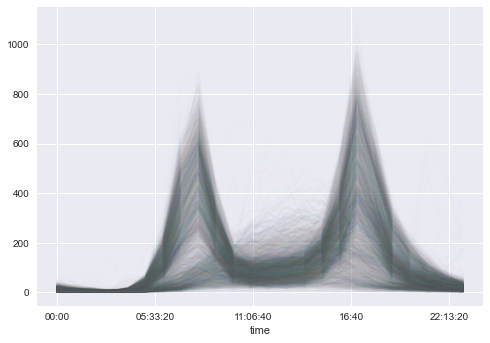

In [67]:
# the above data is so congested that it's hard to see the patterns.
# Instead, adjust the transparency to highlight groupings
pivoted.plot(legend=False, alpha=0.01);

# Part 3

### Git version control when working in Jupyter Lab

- Generally a good idea to restart the kernel and run all to be sure that the code is in the proper order

His workflow
1. Initiate the project folder on GitHub
2. Clone the project into a new local folder<br>
    
```bash
$ gh repo clone robbdunlap/jakevdp_example
```
    * He used SSH but I prefer to use GitHub CLI - I installed the tool using Homebrew

3. Move existing notebook into the new folder
4. git status to see the new notebook is present<br>

```bash
$ git status
```

5. git add to stage the notebook to be added to git control<br>

```bash
$ git add unsupervised_learning.ipynb
```

6. git commit to finalize that the notebook is now under git control<br>

```bash
$ git commit -m "added lda analysis"
```

    * the "-m" indicates that the following string is the commit comment
    
7. git push<br>

```bash
$ git push    # he specifies "origin main" after the push command but it works fine without it
              # this probably comes matters when there start to be branches
```

    * For my first attempt I had changes on GitHub that weren't merged with my local copy (I had manually edited the readme on GitHub). These had to be merged locally before pushing the notebook. I first had to do "Git Pull". This popped me into Vi editor. "I" switches from command mode into insert. Enter the necessary text and then hit "esc" to get back to command mode. Typing a colon will drops you to the bottom of the screen where you can enter file related commands. Typing x or wq followed by return will save the file and quit Vi. Can quit Vi by typing q instead but this won't save the changes you've made. I found some relevant Vi instructions here - https://www.cs.colostate.edu/helpdocs/vi.html. After editing the merge comments I then entered "git commit", had to make further comments in Vi, and then "git push" - I didn't need to append "origin main".
    
    
* Can check status and what branch you are on with the "git status" at any time.

* "git diff" will show the difference in the files that have changed within a project. Type "q" to exit the diff screen back to the command prompt

8. When working on a project as a team, the Main branch on GitHub may have been changed since you last pulled it. Before starting new work on the Main, refresh your local copy of the Main branch:

```bash
$ git pull upstream main
```

### Version Control for Jupyter Notebooks
Git/GitHub version control for Jupyter notebooks is difficult because .ipynb files are actually JSON files. They contain the code but also all the output (in a non-human readable binary blob format) plus environmental variables. Diff'ing the files is not a good solution. The following article details the problems and reviews three different packages that solve the notebook diff'ing problem (nbdime, ReviewNB, and Neptune). https://nextjournal.com/schmudde/how-to-version-control-jupyter

# Part 4

```bash
$ git status --ignore
```

This will show at the command line what's listed in the .ignore file. However, it's much simpler just to open the project folder in VSCode and view edit the .ignore file there.

Add a section at the bottom of the file for data. Since the data for this project is stored in the "data" folder then just add the folder location to the .gitignore - there are size limits to the amount of data you can store on GitHub. It's better to provide links to the data rather than the actual data (hence the function above that will download the data from the API if it's not already in the project data folder on the users computer.

```python
# data
data/
```

# Part 5

### Putting the data import function into a package to make it useable for other projects or sharing with other people

To make a Python package you:
* make a directory for the package
* create a file called __init__.py in the directory
* add the desired code to the __init__.py file

Now, the variables, classes, and functions in the module can be imported into other Python modules. He used the simple example where he created an example folder and an __init__.py within it. He then added the following code to the file:
```python
x = 5.67
```

He then imported the package into another notebook and was able to access the value of x: 
```python
import datadownloader
datadownloader.x
```

Which output the value of x:
```python
5.67
```

You can also put other put other files within the folder that are accessible using the standarad package.subpackage format. See the example datadownloader/data.py. The get_fremont_data() function was moved from this notebook to the module and it works perfectly.

In [41]:
# view parameters for a function in a package
get_fremont_data?

# can also view this as a popup window by pressing <shift-tab> after the function name 

Signature:
get_fremont_data(
    url='https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD',
    filename='data/Fremont.csv',
    force_download=False,
)
Docstring:
Download and cache the Fremont bike route traffic data. Pull data from the cache on rerun unless the "force_download"
   is True or the data doesn't exist in the specificied location.

Parameters
----------
url : string (optional)
    web location of the source data
filename : string (optional)
    location to save the data after downloading
force_download : bool (optional)
    if True, force downloading of the data 

Returns
-------
data : pandas.DataFrame
    The Fremont bike route traffic data
File:      ~/My Drive/Data Science/code_experiments/reproducible data analysis/jakevdp_example/datadownloader/data.py
Type:      function


In [42]:
# see the code of a function in the package 
get_fremont_data??

Signature:
get_fremont_data(
    url='https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD',
    filename='data/Fremont.csv',
    force_download=False,
)
Source:   
def get_fremont_data(url=fremont_data_url, 
                    filename='data/Fremont.csv', 
                    force_download=False):
    """Download and cache the Fremont bike route traffic data. Pull data from the cache on rerun unless the "force_download"
       is True or the data doesn't exist in the specificied location.

    Parameters
    ----------
    url : string (optional)
        web location of the source data
    filename : string (optional)
        location to save the data after downloading
    force_download : bool (optional)
        if True, force downloading of the data 

    Returns
    -------
    data : pandas.DataFrame
        The Fremont bike route traffic data
    """
    
    if force_download or not os.path.exists(filename):
        data = pd.read_csv(URL, index_col='Date'

# Part 6

### Unit Testing

* use [PyTest](https://docs.pytest.org/) for making unit tests
* create a folder within the package folder (datadownloader) called tests
    * all unit tests files should be created within the folder
* Create the new test file
    * unit test files should start with "test_" in their name and then generally the module name 
    * for our test it's "test_data.py" since we're testing the data module

In [43]:
# can run this command at the command line in a shell or within the notebook
# using the command prompt magic command <!>

# verify that your are in the project folder
!pwd

# run the test command
!python -m pytest datadownloader

/Users/robbdunlap/My Drive/Data Science/code_experiments/reproducible data analysis/jakevdp_example
/Users/robbdunlap/opt/anaconda3/envs/reproanal/bin/python: No module named pytest


* pytest collected test items within the datadownloader package by looking for the "tests" folder. It then runs that functions and makes sure all the assertions passed
* unit tests also measures the time for execution. This can be really useful for identifying functions within your code that are non-performant and can guide refactoring
* he explained how to create a "make file" which is just a way of storing command line prompts that you can execute with a "make" command instead of having to remember the full command prompt. I didn't do this because I executed the test command in the notebook above instead of using a shell. First, he created a new file in project folder called "Makefile". He then added the following code to the file:
```python
test:
        python -m pytest datadownloader
```

* he then executed the Makefile to confirm that it worked:
```bash
$ make test
```
<br>
* which output the test results. It's easier to remember "make test" rather than the specific command prompt to execute the test.

# Part 7
### Refactoring the date parsing when importing the CSV to make it faster

* the original method of reading the csv and parsing the dates is slow. This is because with "parse_dates=True", Pandas is looking at each string individually and trying to infer it's datetime format, and then converting it. In this case, since we know the datetime format, we can drammatically speed up parsing by specificying the format. This way, Pandas doesn't have to evaluate each line in the csv file. However, if in the future the data provider changes the datetime format then our parsing won't work. He wraps the parsing in a try/except statement to allow it to fallback to the slower auto-parsing if the format has changed.
* use python strftime format to guide datetime converstion. A good guide can be found at https://strftime.org/
* the original code block was


```python
    data = pd.read_csv(URL, index_col='Date', parse_dates=True)
```

* instead we'll change it to import the datetime column in the index as a string and then we'll convert it to Pandas datetime format using the appropriate formatting guide

```python
    data = pd.read_csv(URL, index_col='Date')
    pd.to_datetime(data.index, format='%m/%d/%Y %H:%M:%S %p'    
    # the '%p' at the end is the AM/PM indicator
```

* this make the import almost instantaneous

In [44]:
# run the test command
!python -m pytest datadownloader

/Users/robbdunlap/opt/anaconda3/envs/reproanal/bin/python: No module named pytest


* The pytest time didn't change between the two versions for me - not sure why. It could be something about pytest or it could be that Pandas is better about datetime parsing since the video was made in 2017. 

# Part 8
### Fixing a broken function and the unit test

* the date format in his example is different from the current format. Originally it was in a mm/dd/yyyy h/m/s am/pm format but it has since changed to a big endian 24-hour format (yyyy/mm/dd h/m/s). This caused a problem in his code because he used "H" for hour instead of "I" (H is for 24 hour time format and I is for 12 hour). So, he had to adjust the time format in get_fremont_data. Also, he pointed out that this really should have been part of the test module so he added the below line as part of the test:


```python
    assert len(np.unique(data.index.time)) == 24
```

* this test will allow the user to know if the data format isn't imported with 24 hour time. Personally, I think that the test should assert that the data matches the specified format instead of just a portion of it but I don't currently know how to implement that. Also, the test should be executed everytime data is redownloaded from the Fremont server - that would take some refactoring.

# Part 8.5
### PCA and Guassian Mixture Model to identify commute patterns and outliers
https://www.youtube.com/watch?v=1kA7oD7ftsM&list=PLYCpMb24GpOC704uO9svUrihl-HY1tTJJ&index=9

In [45]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [46]:
pivoted.shape

(24, 3345)

Can kind of think of the pivoted df (each row is an hour of the day and each column is a different day) as a transpose of tidy data version of the data (tidy data = each row is an observation and each column is a variable). We're going to use SciKitLearn to reduce the dimensionality of the data using PCA. 

In [47]:
# we need the data in an np array for PCA analysis.
# the PCA will not accept na values hence fillna(0).
# the ".values" in pandas does this for us.
X = pivoted.fillna(0).T.values
X.shape

(3345, 24)

In [48]:
# conduct PCA, reduce dimensionality to 2 (hence, the "2" in parentheses)
# ".fit(X)" is passing X into the PCA function
# if you don't specify the solver then PCA will use a random solver, hence
# why svd_solver was chosen.

X2 = PCA(2, svd_solver='full').fit_transform(X)
X2.shape

(3345, 2)

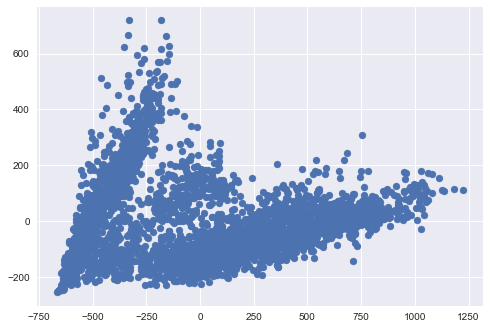

In [49]:
plt.scatter(X2[:,0],X2[:,1])

### Big difference
The video is from 2017 and there were two distinct clusters vs. three here. This is probably due to the pandemic and people working from home. Interesting!

# Show a comparison of pre-covid vs covid data

In [50]:
# use Gaussian Mixture Model to identify the clusters
gmm = GaussianMixture(2)
gmm.fit(X)
labels = gmm.predict(X)
labels

array([1, 1, 1, ..., 0, 1, 1])

/var/folders/87/33lmw8sj3sbc1fnxmv660t480000gn/T/ipykernel_18590/153800693.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


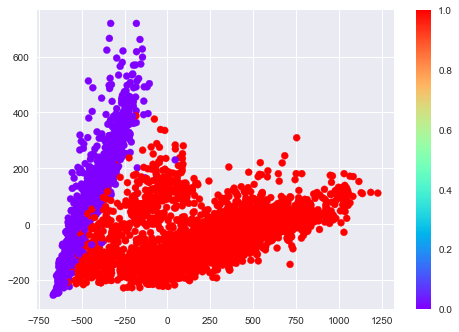

In [51]:
plt.scatter(X2[:,0],X2[:,1], c=labels, cmap='rainbow')
plt.colorbar();

In [ ]:
####### Add another plot showing the impact of using 2 centroids for prepandemic data (pandemic_start_date). The hypothesize that 
####### the new lobe in the middle is pandemic weekday activity. Plot another GMM with 3 groups and state the hypothesis that the 
####### GMM is not identifying the lobe correctly. Maybe try 4-6 groups for giggles, but this shouldn't giive a correct answer either.

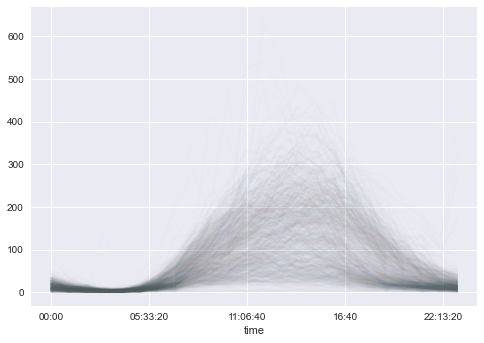

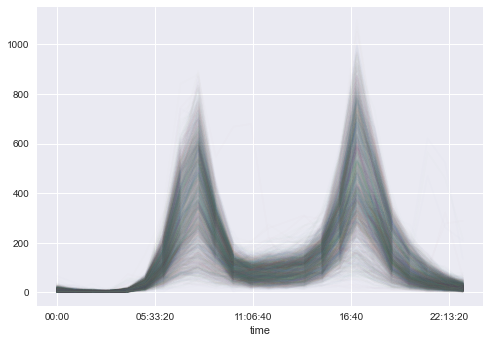

In [52]:
pivoted.T[labels == 0].T.plot(legend = False, alpha = 0.01);
pivoted.T[labels == 1].T.plot(legend = False, alpha = 0.01);

In [69]:
# covid = pivoted[]
all_data = pivoted.T
all_data.index = pd.to_datetime(all_data.index)
# covid = all_data.loc['2020-04-01':'2022-01-10']
# before_covid = all_data.loc['2001-01-01':'2020-03-31']

covid = all_data[all_data.index.date >= pandemic_start_date]
before_covid = all_data[all_data.index.date < pandemic_start_date]

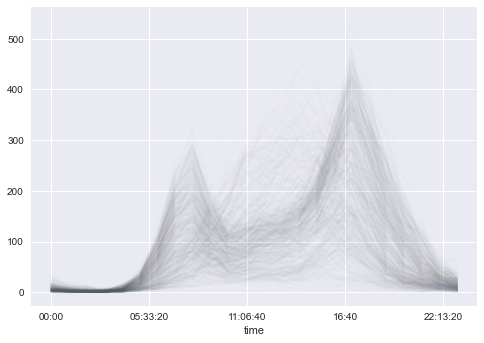

In [70]:
covid.T.plot(legend = False, alpha = 0.01);

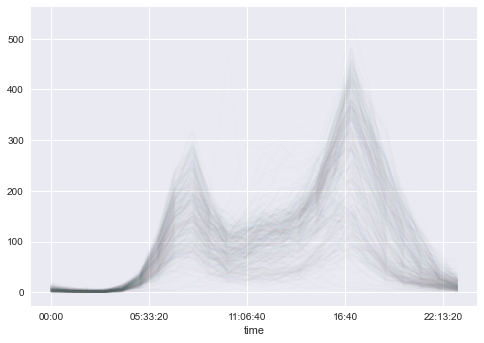

In [71]:
covid_weekday = covid[covid.index.dayofweek<5]
covid_weekday.T.plot(legend = False, alpha = 0.01);

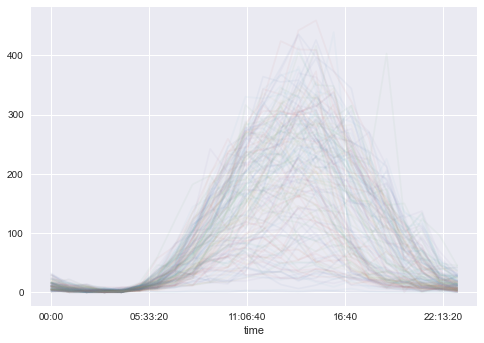

In [72]:
covid_weekend = covid[covid.index.dayofweek>4]
covid_weekend.T.plot(legend = False, alpha = 0.05);

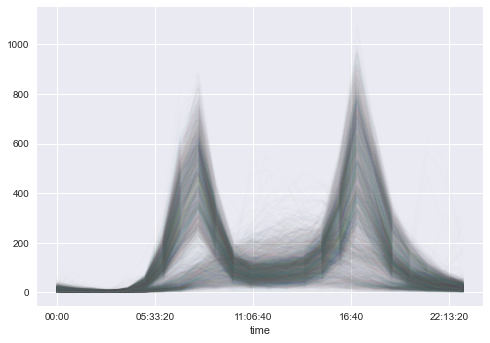

In [73]:
before_covid.T.plot(legend = False, alpha = 0.01);

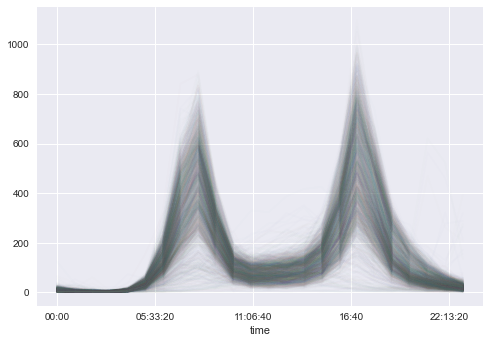

In [74]:
before_covid_weekday = before_covid[before_covid.index.dayofweek<5]
before_covid_weekday.T.plot(legend = False, alpha = 0.01);

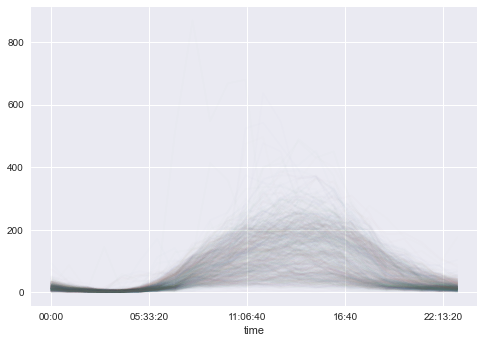

In [75]:
before_covid_weekend = before_covid[before_covid.index.dayofweek>4]
before_covid_weekend.T.plot(legend = False, alpha = 0.01);

/var/folders/87/33lmw8sj3sbc1fnxmv660t480000gn/T/ipykernel_18590/2577686604.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


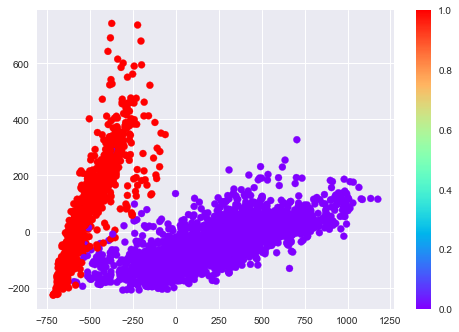

In [77]:
# we need the data in an np array for PCA analysis.
# the PCA will not accept na values hence fillna(0).
# the ".values" in pandas does this for us.
X_before_covid = before_covid.fillna(0).values

# conduct PCA, reduce dimensionality to 2 (hence, the "2" in parentheses)
# ".fit(X)" is passing X into the PCA function
# if you don't specify the solver then PCA will use a random solver, hence
# why svd_solver was chosen.

X2_before_covid = PCA(2, svd_solver='full').fit_transform(X_before_covid)

# use Gaussian Mixture Model to identify the clusters
gmm = GaussianMixture(2)
gmm.fit(X_before_covid)
before_covid_labels = gmm.predict(X_before_covid)

plt.scatter(X2_before_covid[:,0],X2_before_covid[:,1], c=before_covid_labels, cmap='rainbow')
plt.colorbar();

/var/folders/87/33lmw8sj3sbc1fnxmv660t480000gn/T/ipykernel_18590/1925193620.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


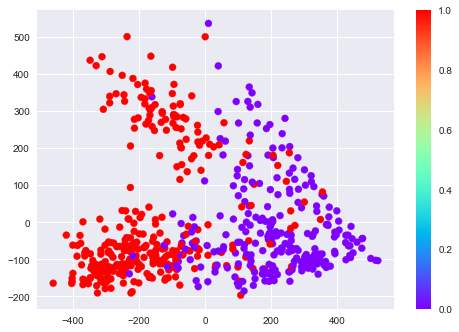

In [78]:
# we need the data in an np array for PCA analysis.
# the PCA will not accept na values hence fillna(0).
# the ".values" in pandas does this for us.
X_covid = covid.fillna(0).values

# conduct PCA, reduce dimensionality to 2 (hence, the "2" in parentheses)
# ".fit(X)" is passing X into the PCA function
# if you don't specify the solver then PCA will use a random solver, hence
# why svd_solver was chosen.

X2_covid = PCA(2, svd_solver='full').fit_transform(X_covid)

# use Gaussian Mixture Model to identify the clusters
gmm = GaussianMixture(2)
gmm.fit(X_covid)
covid_labels = gmm.predict(X_covid)

plt.scatter(X2_covid[:,0],X2_covid[:,1], c=covid_labels, cmap='rainbow')
plt.colorbar()

/var/folders/87/33lmw8sj3sbc1fnxmv660t480000gn/T/ipykernel_18590/2049025873.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


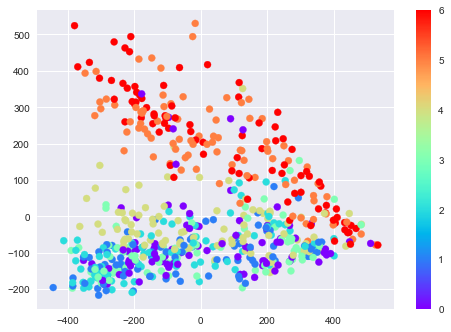

In [63]:
dayofweek_covid = pd.DatetimeIndex(covid.T.columns).dayofweek
plt.scatter(X2_covid[:,0],X2_covid[:,1], c=dayofweek_covid, cmap='rainbow')
plt.colorbar()

### Thoughts
The PCA transform of the data for covid is much different than for before_covid. I think there are two experiments that are worth performing:
1. Take all data and create a label column that divides it up into 4 categories:
    1. before_covid weekday
    2. before_covid weekend
    3. covid weekday
    4. covid weekend  

Then plot labelled PCA of before_covid and covid on 2x1 subplots for comparison

2. Show hourly plot of the two different domains (before_covid and covid) with data separated into 3 groups (6 subplots):
    1. before_covid M-Th
    2. before_covid F
    3. before_covid weekend
    4. covid M-Th
    5. covid F
    6. covid weekend

In [64]:
data

,Total,East,West
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
...,...,...,...
2021-11-30 19:00:00,72.0,24.0,48.0
2021-11-30 20:00:00,26.0,8.0,18.0
2021-11-30 21:00:00,29.0,15.0,14.0


In [65]:
data_w_labels.index > '2021-11-30'

NameError: name 'data_w_labels' is not defined

In [ ]:
(data_w_labels.index.dayofweek == 5) | (data_w_labels.index.dayofweek == 1)

In [ ]:
%%html
<!-- code to get the markdown table to be left aligned in the output rather than centered -->
<style>
table {float:left}
</style>

# covid-status and day-group classification
|day-group\covid-class|before_covid|covid|
|:--:|:--:|:--:|
|m-th|0|3|
|f|1|4|
|sa-su|2|5|


In [ ]:
# create the new columns for labelling points on the graphs quickest
# and easiest to create the covid_class then generate the 
# day-group/covid-class column then delete the covid-class column

data_w_labels = data.copy()
data_w_labels['covid_class'] = np.where(data_w_labels.index > '2020-03-01', 3, 0)
data_w_labels['day_class'] = np.where(data_w_labels.index.dayofweek > 4, 2, 0)
data_w_labels['day_class'] = np.where(data_w_labels.index.dayofweek == 4, 1, data_w_labels['day_class'])
data_w_labels['day_check'] = data_w_labels.index.dayofweek
data_w_labels.sample(20)

In [ ]:
# day of week coloring of PCA for all data 
# PCA transform of X;
# X = pivoted.fillna(0).T.values;
# pivoted = data.pivot_table('Total', index=data.index.time, columns=data.index.date));
# data.columns = index(datetime), Total, East, West --> see data.head(1) above.

# create dayofweek labels for PCA plot
dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek

plt.scatter(X2[:,0],X2[:,1], c=dayofweek, cmap='rainbow')
plt.colorbar()

It really looks like there are three groups to me and that the middle group is probably riding during the pandemic, and thus the Gaussian Mixture Model needs to be tuned better

In [ ]:
dates = pd.DatetimeIndex(pivoted.columns)
dates[(labels==2) & (dayofweek < 5)]

In [ ]:

# make the charts without data
f, axes = plt.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True)
# Can unpack the output array immediately by using a tubple instead
# and then use the subsequent axes names for plotting (ax1 instead of axes[0, 0])
# f, (ax1, ax2, ax3, ax4) = plt.subplots(2, 2, sharex=True, sharey=True).
# can also use plt.tight_layout() at the end of the code instead of adding the 
# kwarg constrained_layout=True

f.set_size_inches(11, 10)

# assign the data to a specific chart which matplotlib then graphs
# if it is a y-by-1 or 1-by-x layout then you only need the first positional argument
# an y-by-x layout requires two position arguments (axes[y][x] or can use axes[y, x])
axes[0, 0].scatter(X2_before_covid[:,0],X2_before_covid[:,1])
axes[0, 1].scatter(X2_covid[:,0],X2_covid[:,1])
axes[0, 0].set_title('before_covid')
axes[0, 1].set_title('covid')
# plt.tight_layout()